# Import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2 
import os
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report

# Split data into train, val, test

In [2]:
folder = '/content/drive/MyDrive/SHAPES/shape'
size = 75
batch_size = 32

train_data_gen = ImageDataGenerator(width_shift_range = 0.1, height_shift_range = 0.1, zoom_range=0.1, shear_range=0.1, brightness_range=[0.8,1.2], validation_split=0.15, preprocessing_function=preprocess_input)
train_data = train_data_gen.flow_from_directory(folder, class_mode='categorical', target_size=(size,size), color_mode='rgb', batch_size=batch_size, seed=42, subset='training')

val_data_gen = ImageDataGenerator(validation_split=0.15, preprocessing_function=preprocess_input)
val_data = val_data_gen.flow_from_directory(folder, class_mode='categorical', target_size=(size,size), color_mode='rgb', batch_size=batch_size, seed=42, subset='validation')

test_data_gen = ImageDataGenerator(validation_split=0.10, preprocessing_function=preprocess_input)
test_data = test_data_gen.flow_from_directory(folder, class_mode='categorical', target_size=(size,size), color_mode='rgb', subset='validation', shuffle=False)

Found 255 images belonging to 1 classes.
Found 45 images belonging to 1 classes.
Found 30 images belonging to 1 classes.


# Test shapes

In [3]:
shape = train_data.image_shape # Shape of train images (height,width,channels)
print(shape)

k = train_data.num_classes # Total number of labels or classes
train_samples = train_data.samples # Total number of images in train set
val_samples = val_data.samples # total number of images in validation set

(75, 75, 3)


# Build the model

In [4]:
input = Input(shape=shape)

basemodel = InceptionV3(include_top=False, weights='imagenet', input_shape=shape, pooling='avg') # Basemodel is InceptionV3 with pretrained weights trained on imagenet dataset
basemodel.trainable = False

x = basemodel(input)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(k, activation='softmax')(x)

model = Model(input, output)

87916544/87910968 [==============================] - 1s 0us/step


In [5]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks

In [6]:
stop = EarlyStopping(monitor='val_loss', patience=4, mode='min', restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath='{val_loss:.4f}-weights-{epoch:02d}.hdf5', monitor='val_loss', mode='min', save_best_only=True)

# Summary

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 75, 75, 3)]       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 23,901,985
Trainable params: 2,099,201
Non-trainable params: 21,802,784
_________________________________________________________________


# Train model

In [8]:
res = model.fit(train_data, validation_data=val_data, 
                steps_per_epoch=train_samples/batch_size, 
                validation_steps=val_samples/batch_size,
                epochs=50, callbacks=[stop, checkpoint])

Epoch 1/50
7/7 [==============================] - 153s 15s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/50
7/7 [==============================] - 1s 164ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/50
7/7 [==============================] - 1s 162ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/50
7/7 [==============================] - 1s 161ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/50
7/7 [==============================] - 1s 167ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


# Check model

In [9]:
model.evaluate(val_data)

2/2 [==============================] - 0s 37ms/step - loss: 0.0000e+00 - accuracy: 1.0000


[0.0, 1.0]

# Plot history

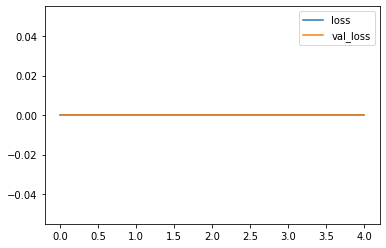

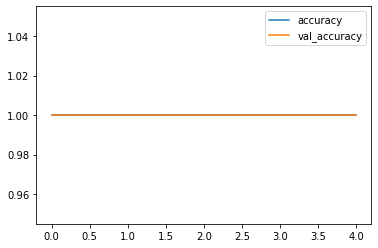

In [10]:
plt.plot(res.history['loss'], label='loss')
plt.plot(res.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.plot(res.history['accuracy'], label='accuracy')
plt.plot(res.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

# Prediction

In [15]:
pred = model.predict(test_data).argmax(axis=1)

# Visualization

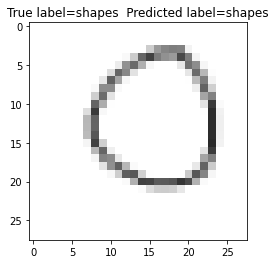

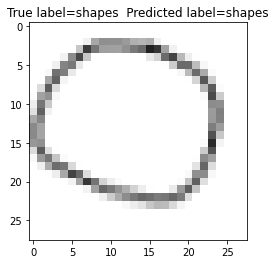

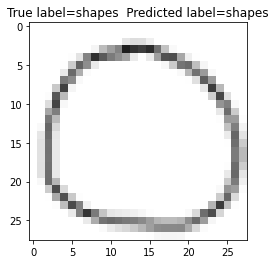

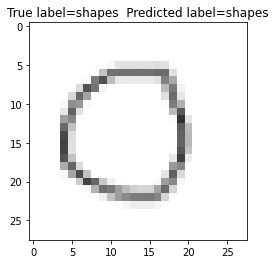

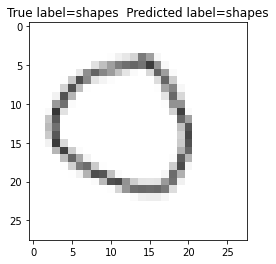

In [16]:
labels = list(train_data.class_indices.keys())
rand = np.random.randint(low=0, high=test_data.samples, size=5)

for n in rand:
  true_index = test_data.classes[n]
  predicted_index = pred[n]
  img = cv2.imread(test_data.filepaths[n])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(img)
  plt.title('True label={}  Predicted label={}'.format(labels[true_index], labels[predicted_index]))
  plt.show()